Access GridMET data from Microsoft Planetary computer using their Stac API. File is Zarr. Access only the data needed, and the variables needed (precipitation only for now). 

Just realized Microsoft Planetary computer only has data through 2020 for this....

In [ ]:
import pystac_client
import planetary_computer
import xarray as xr

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
time_range = "2025-06-24"
bbox = [-126, 24, -65, 50]

asset = catalog.get_collection("gridmet").assets["zarr-abfs"]
asset


In [ ]:
ds = xr.open_zarr(
    asset.href,
    storage_options=asset.extra_fields["xarray:storage_options"],
    **asset.extra_fields["xarray:open_kwargs"]
)
ds

In [5]:
import xarray as xr

ds = xr.open_dataset("data/gridmet/pr_2025.nc", engine="netcdf4")
ds

<xarray.Dataset> Size: 1GB
Dimensions:               (lon: 1386, lat: 585, day: 175, crs: 1)
Coordinates:
  * lon                   (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 5kB 49.4 49.36 49.32 ... 25.11 25.07
  * day                   (day) datetime64[ns] 1kB 2025-01-01 ... 2025-06-24
  * crs                   (crs) uint16 2B 3
Data variables:
    precipitation_amount  (day, lat, lon) float64 1GB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       115
    last_early_slice:           175
    last_provisional_slice:     169
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [12]:
ds_pr_0623 = ds.sel(day='2025-06-23T00:00:00.000000000')
ds_pr_0623

<xarray.Dataset> Size: 7MB
Dimensions:               (lon: 1386, lat: 585, crs: 1)
Coordinates:
  * lon                   (lon) float64 11kB -124.8 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 5kB 49.4 49.36 49.32 ... 25.11 25.07
    day                   datetime64[ns] 8B 2025-06-23
  * crs                   (crs) uint16 2B 3
Data variables:
    precipitation_amount  (lat, lon) float64 6MB ...
Attributes: (12/22)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    last_permanent_slice:       115
    last_early_slice:           175
    last_provisional_slice:     169
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

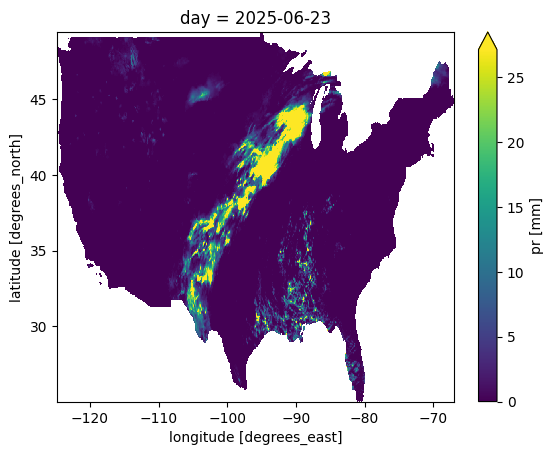

In [14]:
ds_pr_0623['precipitation_amount'].plot(robust=True)